In [2]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from pyproj import Transformer
from datetime import datetime
import json
import re
import os
import zipfile
from datetime import datetime
from fuzzywuzzy import process
import logging
import warnings
import shutil
import hvplot.pandas
from shapely.geometry import Point, Polygon, box
import panel as pn
from bokeh.palettes import Inferno256

#### Preprocessing data

##### Filtering by specific postal code for spatial map plotting (Tuas)

In [3]:
# Getting coordinates of polygons
import geopandas as gpd

geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\SG_geojson\\SG.geojson"
geo_data = gpd.read_file(geojson_path)

In [11]:
blocks_of_interest = ['8', '10', '12', '14', '6', '16', '18', '58', '60', '62', '64', '66', '68', '70', '72', '74', '18']

polygons = {}
tuas_polygons = gpd.GeoDataFrame(columns=['geometry', 'addr_street', 'addr_housenumber'])

# Populating the dictionary with polygon data
for block in blocks_of_interest:
    matching_features = geo_data[(geo_data['addr_street'].str.contains("Tuas South Street 5", na=False)) & 
                                (geo_data['addr_housenumber'] == f"{block}")]

    if not matching_features.empty:
        polygon = matching_features.iloc[0]['geometry']
        polygons[f'polygon_{block}'] = polygon
        tuas_polygons = pd.concat([tuas_polygons, matching_features[['geometry', 'addr_street', 'addr_housenumber']]], ignore_index=True)
        print(polygons[f'polygon_{block}'])
    else:
        print(f"No matching features found for block {block}.")

# Converting the dictionary to a GeoDataFrame
# Create a list of the polygons and set it as the 'geometry' column in a new GeoDataFrame
polygon_data = list(polygons.values())

# Now 'tuas_polygons' is a GeoDataFrame with the 'geometry' column containing the polygon information.
print(tuas_polygons)

POLYGON ((103.6253826 1.296722, 103.6259768 1.2964981, 103.6260502 1.2966928, 103.625456 1.2969166, 103.6253826 1.296722))
POLYGON ((103.6252304 1.2963046, 103.6258405 1.2960748, 103.6259422 1.2963444, 103.6255728 1.2964835, 103.625546 1.2964123, 103.6253051 1.296503, 103.6252304 1.2963046))
POLYGON ((103.6250215 1.2959266, 103.6257117 1.2956666, 103.625809 1.2959247, 103.6254171 1.2960723, 103.6253902 1.296001, 103.6253122 1.2960304, 103.625338 1.2960988, 103.6251177 1.2961818, 103.6250919 1.2961134, 103.6250215 1.2959266))
POLYGON ((103.6249362 1.2954636, 103.625529 1.2952402, 103.6256035 1.2954378, 103.6250106 1.2956612, 103.6249362 1.2954636))
POLYGON ((103.6256922 1.2971498, 103.6261496 1.2969775, 103.626225 1.2971774, 103.6257675 1.2973497, 103.6256922 1.2971498))
POLYGON ((103.6248001 1.2951171, 103.6254098 1.2948874, 103.6254864 1.2950909, 103.6248768 1.2953205, 103.6248001 1.2951171))
POLYGON ((103.624642 1.2947174, 103.625237 1.2944933, 103.6253111 1.2946901, 103.6247162 1.29

In [5]:
# Getting postal code
postalcode_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\ADDRPT.geojson"

# Load GeoJSON data into a GeoDataFrame
postalcode_gdf = gpd.read_file(postalcode_geojson_path)

# print(postalcode_gdf.columns)

def extract_postal_codes(geojson_path, road_name_keyword, blocks_of_interest):
    # Filter for road name containing the specified keyword and block numbers of interest
    filtered_gdf = postalcode_gdf[
        (postalcode_gdf['ROAD_NAME'].str.contains(road_name_keyword, case=False, na=False)) &
        (postalcode_gdf['HOUSE_BLK_NO'].isin(blocks_of_interest))
    ]

    # Extract the postal codes
    postal_codes = filtered_gdf['POSTAL_CODE'].dropna().unique()

    return postal_codes

# Extract postal codes
postal_codes = extract_postal_codes(geojson_path, "TUAS SOUTH STREET 5", blocks_of_interest)

# Print the results
print("Postal Codes in Tuas for specified blocks:", postal_codes)

Postal Codes in Tuas for specified blocks: ['637808' '637801' '637802' '637803' '637796' '637793' '637791' '637792'
 '637804' '637805' '637800' '637795' '637794' '637790' '637806' '637807']


In [6]:
print(len(postal_codes) == len(polygons))

True


In [7]:
import geopandas as gpd
import numpy as np

# Define a dictionary to store coordinates
coordinates_dict = {}

# Function to get coordinates by postal code
def get_coordinates_by_postal_code(postal_code):
    postal_data = postalcode_gdf[postalcode_gdf['POSTAL_CODE'] == postal_code]
    if not postal_data.empty:
        # Extract the coordinates of the first matching entry
        longitude = postal_data.geometry.x.values[0]
        latitude = postal_data.geometry.y.values[0]
        return longitude, latitude
    else:
        return None, None

# Fetch coordinates for each postal code and store them
for postal_code in postal_codes:
    coordinates_dict[postal_code] = get_coordinates_by_postal_code(postal_code)

# Extract coordinates and calculate the central point
longitudes = []
latitudes = []

for postal_code, coords in coordinates_dict.items():
    if coords[0] is not None and coords[1] is not None:
        longitudes.append(coords[0])
        latitudes.append(coords[1])
        print(f'Coordinates for postal code {postal_code}: Longitude {coords[0]}, Latitude {coords[1]}')

if longitudes and latitudes:
    avg_longitude = np.mean(longitudes)
    avg_latitude = np.mean(latitudes)
    print(f'\nCentral coordinates:')
    print(f'Longitude: {avg_longitude}, Latitude: {avg_latitude}')
else:
    print('Coordinates for some or all postal codes not found.')

Coordinates for postal code 637808: Longitude 103.62507639847082, Latitude 1.2976286693869217
Coordinates for postal code 637801: Longitude 103.62415963793315, Latitude 1.2951103746281685
Coordinates for postal code 637802: Longitude 103.62438604256748, Latitude 1.2957112692952846
Coordinates for postal code 637803: Longitude 103.6243834853277, Latitude 1.2957441940733267
Coordinates for postal code 637796: Longitude 103.62536110097575, Latitude 1.2944259603884993
Coordinates for postal code 637793: Longitude 103.62544947276622, Latitude 1.295906479085173
Coordinates for postal code 637791: Longitude 103.62577104052976, Latitude 1.2967118335708088
Coordinates for postal code 637792: Longitude 103.62561996344215, Latitude 1.296299212800991
Coordinates for postal code 637804: Longitude 103.62482050538428, Latitude 1.2961707177837316
Coordinates for postal code 637805: Longitude 103.62489034421174, Latitude 1.2963576907098022
Coordinates for postal code 637800: Longitude 103.6243499073147

In [8]:
# # Converting x and y to coordinates for latitude/longitude
# # FOR LANDSAT7 

# import rasterio
# import numpy as np
# import pandas as pd
# from pyproj import Transformer
# from shapely.geometry import Point

# global filtered_df

# def preprocessing(file_path):   
#     global filtered_df
    
#     # Open your GeoTIFF file
#     with rasterio.open(file_path) as src:
#         array = src.read()
#         transform = src.transform
#         src_crs = src.crs  # Source CRS
#         # dest_crs = 'EPSG:4326'  # WGS 84

#         # Create a transformer object to convert from src_crs to dest_crs
#         transformer = Transformer.from_crs(src_crs, 'EPSG:4326', always_xy=True)

#         # Get arrays of column and row indices
#         cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
        
#         # Convert meshgrid arrays to coordinate arrays using rasterio's method, which are 2D
#         xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        
#         # Flatten the coordinate arrays to pass to transform function
#         lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

#         # Create DataFrame and convert to GeoDataFrame
#         df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
#         for i, band in enumerate(src.read(masked=True)):
#             df[src.descriptions[i]] = band.flatten()

#         # # Convert 'SR_QA_AEROSOL' to integer for bitwise operation
#         # df['SR_QA_AEROSOL'] = df['SR_QA_AEROSOL'].astype(int)

#         # # Filter out pixels with valid aerosol retrieval and high aerosol level
#         # # Assuming 'SR_QA_AEROSOL' is the name of the QA aerosol band in the data
#         # valid_aerosol = (df['SR_QA_AEROSOL'] & 2) == 2  # Bit 1 must be set for valid retrieval
#         # high_aerosol = (df['SR_QA_AEROSOL'] & 192) == 192  # Bits 6-7 must be set to 11 for high aerosol
#         # filter_mask = valid_aerosol & high_aerosol
#         # df_filtered = df[-filter_mask]

#         df_filtered = df
        
#         # Scale and offset specific bands
#         df_filtered['ST_B6_Celsius'] = df_filtered['ST_B6'] * 0.00341802 + 149 - 273.15
#         df_filtered = df_filtered[df_filtered['ST_B6_Celsius'] >= 20]  # Drop rows below 20 degrees Celsius
        
#         bands_to_scale = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
#         for band in bands_to_scale:
#             df_filtered[f"{band}_Scaled"] = df_filtered[band] * 2.75e-05 - 0.2

#         additional_scales = {
#             'ST_ATRAN': 0.0001, 'ST_CDIST': 0.01, 'ST_DRAD': 0.001, 
#             'ST_EMIS': 0.0001, 'ST_EMSD': 0.0001, 'ST_QA': 0.01, 
#             'ST_TRAD': 0.001, 'ST_URAD': 0.001
#         }

#         for band, scale in additional_scales.items():
#             df_filtered[f"{band}_Scaled"] = df_filtered[band] * scale

#         gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.Longitude, df_filtered.Latitude))
#         gdf.set_crs('EPSG:4326', inplace=True)

#         print("Total number of valid pixels: " + str(len(gdf)))
#         print(df[['Latitude', 'Longitude']].head())

#         gdf = gdf.to_crs('EPSG:3857')

#         transformer_2 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

#         avg_longitude_3857, avg_latitude_3857 = transformer_2.transform(avg_longitude, avg_latitude)

#         # Define your point of interest and buffer distance in meters
#         poi = Point(avg_longitude_3857, avg_latitude_3857)
#         desired_radius = 1000
#         buffer = poi.buffer(desired_radius)  # Convert meters to degrees approximately

#         # Filter points within the buffer
#         filtered_gdf = gdf[gdf.geometry.within(buffer)]

#         # Save or process your filtered data
#         print(f"\nNumber of points within {desired_radius}m radius: {len(filtered_gdf)}")
#         #print(filtered_gdf['ST_B10_Celsius'].head())

#         filtered_gdf = filtered_gdf.to_crs('EPSG:4326')

#     return filtered_gdf

In [64]:
# FOR LANDSAT 8/9
# Converting x and y to coordinates for latitude/longitude
import rasterio
import numpy as np
import pandas as pd
from pyproj import Transformer
from shapely.geometry import Point

global filtered_df

def preprocessing(file_path):   
    global filtered_df
    
    # Open your GeoTIFF file
    with rasterio.open(file_path) as src:
        array = src.read()
        transform = src.transform
        src_crs = src.crs  # Source CRS
        dest_crs = 'EPSG:4326'  # WGS 84

        # Create a transformer object to convert from src_crs to dest_crs
        transformer = Transformer.from_crs(src_crs, dest_crs, always_xy=True)

        # Get arrays of column and row indices
        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
        
        # Convert meshgrid arrays to coordinate arrays using rasterio's method, which are 2D
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        
        # Flatten the coordinate arrays to pass to transform function
        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())

        # Create DataFrame and convert to GeoDataFrame
        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
        for i, band in enumerate(src.read(masked=True)):
            df[src.descriptions[i]] = band.flatten()

        # # Convert 'SR_QA_AEROSOL' to integer for bitwise operation
        # df['SR_QA_AEROSOL'] = df['SR_QA_AEROSOL'].astype(int)

        # # Filter out pixels with valid aerosol retrieval and high aerosol level
        # # Assuming 'SR_QA_AEROSOL' is the name of the QA aerosol band in the data
        # valid_aerosol = (df['SR_QA_AEROSOL'] & 2) == 2  # Bit 1 must be set for valid retrieval
        # high_aerosol = (df['SR_QA_AEROSOL'] & 192) == 192  # Bits 6-7 must be set to 11 for high aerosol
        # filter_mask = valid_aerosol & high_aerosol
        # df_filtered = df[-filter_mask]

        df_filtered = df
        
        # Scale and offset specific bands
        df_filtered['ST_B10_Celsius'] = df_filtered['ST_B10'] * 0.00341802 + 149 - 273.15
        df_filtered = df_filtered[df_filtered['ST_B10_Celsius'] >= 20]  # Drop rows below 20 degrees Celsius
        
        bands_to_scale = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
        for band in bands_to_scale:
            df_filtered[f"{band}_Scaled"] = df_filtered[band] * 2.75e-05 - 0.2

        additional_scales = {
            'ST_ATRAN': 0.0001, 'ST_CDIST': 0.01, 'ST_DRAD': 0.001, 
            'ST_EMIS': 0.0001, 'ST_EMSD': 0.0001, 'ST_QA': 0.01, 
            'ST_TRAD': 0.001, 'ST_URAD': 0.001
        }

        for band, scale in additional_scales.items():
            df_filtered[f"{band}_Scaled"] = df_filtered[band] * scale

        gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.Longitude, df_filtered.Latitude))
        gdf.set_crs('EPSG:4326', inplace=True)  # Ensure the CRS is set to WGS 84

        print("Total number of valid pixels: " + str(len(gdf)))
        print(df[['Latitude', 'Longitude']].head())

        # Define your point of interest and buffer distance in meters
        poi = Point(avg_longitude, avg_latitude)
        desired_radius = 1000
        buffer = poi.buffer(desired_radius / 111320)  # Convert meters to degrees approximately

        # Filter points within the buffer
        filtered_gdf = gdf[gdf.geometry.within(buffer)]

        # Save or process your filtered data
        print(f"\nNumber of points within {desired_radius}m radius: {len(filtered_gdf)}")
        #print(filtered_gdf['ST_B10_Celsius'].head())

    return filtered_gdf

##### Filtering 30m x 30m pixels based on region of interest

##### Using EPSG:3857 allows you to blow up the pixels in metres because the coordinate representation is in metres

In [49]:
import geopandas as gpd
import hvplot.pandas
import pandas as pd
from shapely.geometry import Polygon, box
import panel as pn
from bokeh.palettes import Inferno256
import numpy as np
import logging

# Suppress warnings
logging.getLogger('bokeh').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # default='warn'

global within_polygon_gdf

def plot_spatial_map(filtered_gdf): 
    global within_polygon_gdf
    
    filtered_gdf = filtered_gdf.to_crs('epsg:3857')

    # print(filtered_gdf['geometry'])

    # Create pixels as 30m x 30m boxes around each point
    # Assuming each point is at the center of the pixel
    half_width = 15  # half the width of the pixel in meters since the EPSG:3857 coordinate system is in metres
    filtered_gdf['geometry'] = filtered_gdf['geometry'].apply(lambda x: box(x.x - half_width, x.y - half_width, x.x + half_width, x.y + half_width))

    #print(filtered_gdf['geometry'])

    # Create a GeoDataFrame from all polygons and convert CRS to match
    polygon_gdf = gpd.GeoDataFrame({'geometry': list(polygons.values())}, crs='epsg:4326')
    polygon_gdf_3857 = polygon_gdf.to_crs('epsg:3857')

    # Filter points that intersect any polygon
    def intersects_any_polygon(point):
        return any(point.intersects(poly) for poly in polygon_gdf['geometry'])
    
    filtered_gdf['intersects'] = filtered_gdf['geometry'].apply(intersects_any_polygon)

    # Check intersection with any polygon
    within_polygon_gdf = filtered_gdf[filtered_gdf['intersects']].copy()

    # print(polygon_gdf_3857['geometry'])

    # Filter points that intersect any polygon
    filtered_gdf['intersects'] = filtered_gdf['geometry'].apply(
        lambda geom: any(geom.intersects(poly) for poly in polygon_gdf_3857['geometry']))
    within_polygon_gdf = filtered_gdf[filtered_gdf['intersects']].copy()

    # print(within_polygon_gdf['SR_QA_AEROSOL'].unique())

    print("Number of pixels in region of interest: " + str(len(within_polygon_gdf)))

    # Print or use the filtered GeoDataFrame as needed
    # print("\nNumber of points within the region of interest: " + str(len(within_polygon_gdf)))

    # # Print the centroids of the intersected pixels
    # for index, row in within_polygon_gdf.iterrows():
    #     centroid = row['geometry'].centroid
    #     print(f"Longitude: {centroid.x}, Latitude: {centroid.y}")

    # Define a function to select a subset of the color palette
    def select_colors(palette, n):
        return [palette[int(i)] for i in np.linspace(0, len(palette)-1, n)]

    # Create a custom color scale using a continuous palette
    custom_palette = select_colors(Inferno256, 256)  # More colors for smoother transitions

    # Create the heatmap using the centroid points of intersected pixels
    heatmap = within_polygon_gdf.hvplot.points('Longitude', 'Latitude', geo=True, c='ST_B10_Celsius', cmap=custom_palette, size=5, tiles='OSM', frame_width=700, frame_height=500, colorbar=True, clim=(20, 40))

    # Plot square polygons with the same color mapping as the points
    squares_plot = within_polygon_gdf.hvplot.polygons('geometry', c='ST_B10_Celsius', cmap=custom_palette, alpha=0.5, colorbar=True, clim=(20, 40))

    # Plot the polygon with visible settings
    polygon_plot = polygon_gdf.hvplot(geo=True, color='red', line_width=3, alpha=0.7)

    # Overlay the polygon onto the heatmap
    overlay_map = polygon_plot * heatmap * squares_plot

    # Set up Panel to display the plot
    # pane = pn.panel(overlay_map)

    # pane.show()
    # pane.save(f'C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\MSE-ES-UHI\\2_landsat\\Heatmaps\\{postal_code_112}_{satellite_image}_LST_Filtered.html', embed=True)

    return overlay_map

#### Plotting LST over time

##### Combining GDFs

In [71]:
import geopandas as gpd
import pandas as pd
import os
import zipfile
from datetime import datetime
import logging
import shutil

# Required data is from 2022 - 2024
year = "2021"

# Suppress warnings
logging.getLogger('bokeh').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # default='warn'

# Specify the zip file and temporary directory for extraction
zip_file_path = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\Landsat8\\{year}.zip"
temp_dir = f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\temp_extract"

# Create a temporary directory if it doesn't exist
os.makedirs(temp_dir, exist_ok=True)

# Extract the .tif files from the zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Initialize an empty list to hold all the GeoDataFrames
gdfs = []

# Walk through the temporary directory and process each .tif file
for filename in os.listdir(f"{temp_dir}\\{year}"):
    if filename.endswith(".tif"):
        print("Currently processing: " + filename)
        file_path = os.path.join(f"{temp_dir}\\{year}", filename)
        
        # Extract the time period from the filename
        # Assuming filename format is "L8_UTC_YYYYMMDD_hhmmss.tif"
        time_str = filename.split('_')[2]
        time_obj = datetime.strptime(time_str, "%Y%m%d")
        
        # Load and preprocess the GeoDataFrame
        gdf = preprocessing(file_path)
        gdf['time'] = time_obj  # Append the datetime object as a new column
        
        # Append the processed GeoDataFrame to the list
        gdfs.append(gdf)

# Combine all GeoDataFrames into one
combined_gdf = pd.concat(gdfs)

shutil.rmtree(f"C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\temp_extract")

# Use the combined GeoDataFrame as needed
print(combined_gdf)

Currently processing: L8_UTC_20210108_031652.tif
Total number of valid pixels: 0
   Latitude   Longitude
0  1.470099  103.589751
1  1.470099  103.590021
2  1.470099  103.590290
3  1.470099  103.590560
4  1.470100  103.590830

Number of points within 1000m radius: 0
Currently processing: L8_UTC_20210124_031646.tif
Total number of valid pixels: 2035629
   Latitude   Longitude
0  1.470099  103.589751
1  1.470099  103.590021
2  1.470099  103.590290
3  1.470099  103.590560
4  1.470100  103.590830

Number of points within 1000m radius: 3454
Currently processing: L8_UTC_20210209_031644.tif
Total number of valid pixels: 128315
   Latitude   Longitude
0  1.470099  103.589751
1  1.470099  103.590021
2  1.470099  103.590290
3  1.470099  103.590560
4  1.470100  103.590830

Number of points within 1000m radius: 0
Currently processing: L8_UTC_20210225_031639.tif
Total number of valid pixels: 1408570
   Latitude   Longitude
0  1.470099  103.589751
1  1.470099  103.590021
2  1.470099  103.590290
3  1.

In [47]:
# import geopandas as gpd
# import hvplot.pandas
# import holoviews as hv
# from bokeh.palettes import Turbo256  # Import a predefined Bokeh palette

# # Assuming 'gdf' is your preloaded GeoDataFrame
# combined_gdf = combined_gdf.to_crs(epsg=3857)  # Convert to Web Mercator for better mapping support

# # Define a function to select a subset of the color palette
# def select_colors(palette, n):
#     return [palette[int(i)] for i in np.linspace(0, len(palette)-1, n)]

# # Create a custom color scale using a continuous palette
# custom_palette = select_colors(Turbo256, 256)  # More colors for smoother transitions

# # Create the heatmap
# heatmap = combined_gdf.hvplot.points('Longitude', 'Latitude', geo=True, c='ST_B10_Celsius',
#                             cmap=custom_palette, size=5,  # Smaller size for finer detail
#                             tiles='OSM', frame_width=700, frame_height=500,
#                             colorbar=True, clim=(20, 40))

# #file_path = "C:/LocalOneDrive/Documents/Desktop/MTI/UHI-Project/MSE-ES-UHI/MSE-ES-UHI/2_landsat/Heatmaps"

# # Set up Panel to display the plot
# heatmap_panel = hv.save(heatmap, '270524_hvPlot_Land_Surface_Temperature_Map_gradient.html', backend='bokeh')

# # Display the plot in the notebook
# heatmap_panel

##### Spatial plot over time

In [54]:
import panel as pn

# Create an interactive plot with filtering based on the GeoDataFrame
def create_interactive_plot(combined_gdf):
    # Create a list of unique dates sorted
    unique_dates = combined_gdf['time'].dt.strftime('%Y-%m-%d').sort_values().unique()
    # print(f"Unique Dates: {unique_dates}")

    date_index_map = {i + 1: date for i, date in enumerate(unique_dates)}

    # Setup an integer slider to select time periods
    time_slider = pn.widgets.IntSlider(name='Select Time', start=1, end=len(unique_dates), value=1, step=1)

    @pn.depends(time_slider.param.value_throttled)
    def dynamic_map(value):
        selected_date = date_index_map[value]
        selected_datetime = pd.to_datetime(selected_date).date()
        
        # Filter data for the selected time
        filtered_data = combined_gdf[combined_gdf['time'].dt.date == selected_datetime]
        print(f"Displaying plot for " + str(selected_date))
        
        # Call plot_spatial_map for the selected time period
        return plot_spatial_map(filtered_data)

    layout = pn.Column(
        "<br>\nInteractive Land Surface Temperature Map",
        time_slider,
        dynamic_map
    )

    return layout

layout = create_interactive_plot(combined_gdf)
# layout.servable()
pn.serve(layout, show=False, start=True)

Displaying plot for 2021-10-31
Number of pixels in region of interest: 66
Launching server at http://localhost:57220


Displaying plot for 2021-11-05
Number of pixels in region of interest: 66
Displaying plot for 2021-11-10
Number of pixels in region of interest: 66
Displaying plot for 2021-10-31
Number of pixels in region of interest: 66
Displaying plot for 2021-11-15
Number of pixels in region of interest: 66


#### Exporting data to .csv

In [72]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import warnings

# Suppress specific FutureWarnings related to GeoPandas
warnings.filterwarnings("ignore", category=FutureWarning, message="The `op` parameter is deprecated")

def filter_and_save_data(year_gdf, polygons, output_file):
    # Ensure polygons are in EPSG:3857
    polygon_gdf = gpd.GeoDataFrame({'geometry': list(polygons.values()), 'BLOCK_NO': list(polygons.keys())}, crs='epsg:4326')
    polygon_gdf = polygon_gdf.to_crs('epsg:3857')

    # Initialize an empty DataFrame to store all filtered data
    all_filtered_data = gpd.GeoDataFrame()

    for date in year_gdf['time'].dt.strftime('%Y-%m-%d').sort_values().unique():
        # Filter data for the specific date
        date_data = year_gdf[year_gdf['time'].dt.strftime('%Y-%m-%d') == date]

        # Convert CRS to EPSG:3857 and create 30m x 30m boxes around each point
        date_data = date_data.to_crs('epsg:3857')
        date_data['geometry'] = date_data['geometry'].apply(
            lambda x: box(x.x - 15, x.y - 15, x.x + 15, x.y + 15))

        # Perform spatial join to determine intersecting polygons
        joined_data = gpd.sjoin(date_data, polygon_gdf, how='inner', op='intersects')

        # Append the filtered data of this date to the all_filtered_data DataFrame
        all_filtered_data = pd.concat([all_filtered_data, joined_data], ignore_index=True)

    # Check if 'index_right' is in the columns and drop it if present
    if 'index_right' in all_filtered_data.columns:
        all_filtered_data.drop(columns=['index_right'], inplace=True)

    # Save the aggregated filtered data to a CSV file
    all_filtered_data.to_csv(output_file, index=False)
    print(f"Data successfully exported to {output_file}")

# Assume combined_gdf is already loaded with time converted to datetime
output_path = 'C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\FilteredData\\Tuas\\Landsat8\\Tuas_Filtered_2021.csv'
filter_and_save_data(combined_gdf, polygons, output_path)

Data successfully exported to C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat8\Tuas_Filtered_2021.csv


##### Codes to combine .csv files for 2022 - 2024

In [75]:
import pandas as pd

# Define the base file path
base_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat9"

# File names
files = [
    r"Tuas_Filtered_2021.csv",
    r"Tuas_Filtered_2022.csv",
    r"Tuas_Filtered_2023.csv",
    r"Tuas_Filtered_2024.csv"
]

# Read and concatenate the CSV files
df_list = [pd.read_csv(f"{base_path}\\{file_name}") for file_name in files]
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(f"{base_path}\\Tuas_Filtered_2021_to_2024.csv", index=False)

print("Files were successfully concatenated and saved.")

Files were successfully concatenated and saved.


## Plot Spatial Map

In [56]:
tuas_2023_csv_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\FilteredData\Tuas\Landsat7\Tuas_Filtered_2017.csv"

tuas_2023_gdf = gpd.GeoDataFrame(pd.read_csv(tuas_2023_csv_path))
geometry = [Point(xy) for xy in zip(tuas_2023_gdf['Longitude'], tuas_2023_gdf['Latitude'])]
geo_tuas_gdf = gpd.GeoDataFrame(tuas_2023_gdf, crs="EPSG:4326", geometry=geometry)

tuas_polygons = tuas_polygons.set_crs('EPSG:4326')
tuas_polygons = tuas_polygons.rename(columns={'addr_housenumber': 'BLOCK_NO'})

tuas_gdf = gpd.GeoDataFrame(tuas_2023_gdf[tuas_2023_gdf['time'] == '2017-07-16'])

In [60]:
from bokeh.palettes import Oranges

def plot_spatial_map_layered(tuas_gdf, tuas_polygons):
    tuas_gdf = tuas_gdf.to_crs('EPSG:3857')
    tuas_gdf['geometry'] = tuas_gdf.geometry.apply(lambda p: box(p.x - 15, p.y - 15, p.x + 15, p.y + 15))

    average_temps_by_blk = tuas_gdf.groupby(['BLOCK_NO'])['ST_B6_Celsius'].mean()

    min_temp = average_temps_by_blk.min()
    max_temp = average_temps_by_blk.max()

    # print(average_temps_by_block)

    tuas_polygons = tuas_polygons.to_crs('EPSG:4326')

    tuas_polygons.reset_index(drop=True, inplace=True)
    
    average_temps_by_blk.rename('Average_Temp', inplace=True)  

    tuas_polygons = tuas_polygons.join(average_temps_by_blk, on='BLOCK_NO')

    tuas_polygons['Average_Temp'].fillna(0, inplace=True)

    # print(all_polygons)

    pixels_plot = tuas_gdf.hvplot.points('Longitude', 'Latitude', geo=True, c='ST_B6_Celsius', cmap=Oranges[256][::-1], frame_width=700, frame_height=500, colorbar=True, clim=(min_temp, max_temp), tiles='OSM', size=10)
    squares_plot = tuas_gdf.hvplot.polygons('geometry', c='ST_B6_Celsius', cmap=Oranges[256][::-1], alpha=0.5, frame_width=700, frame_height=500, colorbar=True, clim=(min_temp, max_temp))
    block_plot = tuas_polygons.hvplot(
        geo=True,
        c='Average_Temp',
        cmap=Oranges[256][::-1],
        clim=(min_temp, max_temp),
        hover_cols=['Average_Temp'],
        tiles='OSM',
        colorbar=True,
        frame_width=500,
        frame_height=450,
        line_color='black'
    )

    # combined_plot = block_plot * squares_plot * pixels_plot

    return block_plot * squares_plot * pixels_plot

In [58]:
# Map blocks to grouped blocks based on provided polygon numbers
treatment_polygons = ['polygon_8', 'polygon_10', 'polygon_12', 'polygon_14']
treatment_blk_no = ['8', '10', '12', '14']
control_polygons = ['polygon_6', 'polygon_16', 'polygon_18', 'polygon_58', 'polygon_60', 'polygon_62', 'polygon_64', 'polygon_66', 'polygon_68', 'polygon_70', 'polygon_72', 'polygon_74']
control_blk_no = ['6', '16', '18', '58', '60', '62', '64', '66', '68', '70', '72', '74', '18']

In [59]:
tuas_treatment_gdf = tuas_gdf[tuas_gdf['BLOCK_NO'].isin(treatment_polygons)]
tuas_treatment_polygons = tuas_polygons[tuas_polygons['BLOCK_NO'].isin(treatment_blk_no)]

Number of duplicate geometries: 10
Duplicate rows:
      Longitude  Latitude   SR_B1    SR_B2    SR_B3    SR_B4    SR_B5  \
167  103.625709  1.296464  9184.0   9935.0  11030.0  11922.0  12077.0   
168  103.625979  1.296464  9113.0   9546.0  10267.0  11767.0  11533.0   
176  103.625709  1.296464  9184.0   9935.0  11030.0  11922.0  12077.0   
177  103.625979  1.296464  9113.0   9546.0  10267.0  11767.0  11533.0   
178  103.625170  1.296193  9043.0   9625.0  10822.0  12229.0  12168.0   
179  103.625440  1.296193  9184.0   9858.0  11376.0  12229.0  12440.0   
186  103.625170  1.296193  9043.0   9625.0  10822.0  12229.0  12168.0   
187  103.625440  1.296193  9184.0   9858.0  11376.0  12229.0  12440.0   
192  103.625440  1.295650  9256.0  10014.0  11446.0  12384.0  12531.0   
205  103.625440  1.295650  9256.0  10014.0  11446.0  12384.0  12531.0   

       SR_B7  SR_ATMOS_OPACITY  SR_CLOUD_QA  ...  ST_CDIST_Scaled  \
167  11271.0             198.0          4.0  ...             0.00   
168  10

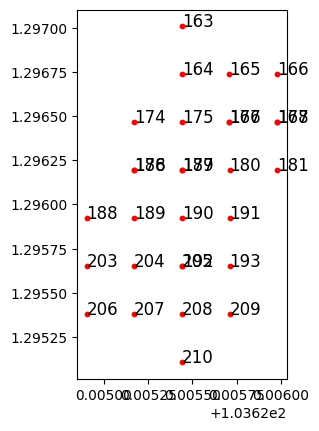

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Check for duplicate geometries
duplicates = tuas_treatment_gdf['geometry'].duplicated(keep=False)  # keep=False marks all duplicates as True
if duplicates.any():
    print(f"Number of duplicate geometries: {duplicates.sum()}")
    print("Duplicate rows:")
    print(tuas_treatment_gdf[duplicates])  # Print the rows where duplicates are found

# Check geometry validity
valid_geometries = tuas_treatment_gdf['geometry'].is_valid
if not valid_geometries.all():
    print("Invalid geometries found:")
    print(tuas_treatment_gdf[~valid_geometries])  # Print rows with invalid geometries

# Plot each point with a label for clarity
fig, ax = plt.subplots()
tuas_treatment_gdf.plot(ax=ax, color='red', markersize=10)  # Adjust markersize for visibility
for idx, row in tuas_treatment_gdf.iterrows():
    ax.text(row['geometry'].x, row['geometry'].y, str(idx), fontsize=12)  # Label each point with its index

plt.show()

In [61]:
plot_spatial_map_layered(tuas_treatment_gdf, tuas_treatment_polygons)

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (Average_Temp)
   .Polygons.II :Polygons   [x,y]   (ST_B6_Celsius)
   .WMTS.II     :WMTS   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]   (ST_B6_Celsius)

In [66]:
tuas_control_gdf = tuas_gdf[~tuas_gdf['BLOCK_NO'].isin(treatment_polygons)]
tuas_control_polygons = tuas_polygons[~tuas_polygons['BLOCK_NO'].isin(treatment_blk_no)]

In [67]:
plot_spatial_map_layered(tuas_control_gdf, tuas_control_polygons)

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (Average_Temp)
   .Polygons.II :Polygons   [x,y]   (ST_B6_Celsius)
   .WMTS.II     :WMTS   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]   (ST_B6_Celsius)